# Avaliação do Mecanismo de Busca

Esse notebook foi desenvolvido a fim de avaliar o mecanismo de busca construído na parte 1 do trabalho do curso Busca e Mineração de Texto. Nos exemplos presentes, foram gerados os dados e gráficos para o arquivo 'resultados-stemmer.csv'. Porém, o mesmo notebook pode ser utilizado para gerar as métricas de avaliação para o arquivo onde temos os resultados sem a aplicação de um Stemmer. No repositório do GitHub temos a pasta `avalia` onde estarão presentes todos os dados e gráficos gerados utilizando o notebook e conforme foi pedido pelo enunciado do trabalho.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# Carregando os arquivos gerados pelo mecanismo

Primeiro é mostrado como estão organizados os arquivos CSV, resultados esperados e resultados retornados pelo mecanismo, respectivamente.

In [2]:
expected = pd.read_csv("../results/expected.csv", sep=";")
expected.head()

,QueryNumber,DocNumber,DocVotes
0,1,139,4
1,1,151,4
2,1,166,1
3,1,311,1
4,1,370,2


In [3]:
results = pd.read_csv("../results/results-stemmer.csv", sep=";", converters={"DocInfos": pd.eval})
results.head()

,QueryNumber,DocInfos
0,1,"[1, 437, 0.27588934462955456]"
1,1,"[2, 498, 0.20844373959940954]"
2,1,"[3, 484, 0.18440699663023122]"
3,1,"[4, 754, 0.17310807431022798]"
4,1,"[5, 957, 0.16879740146000236]"


# Obtendo dados dos arquivos

Agora vamos definir duas funções, para obter dois dicionários. Ambos os dicionários terão o formato de `QueryNumber: [lista com números de documentos]`. No dicionário "expected_docs" teremos os números das consultas linkadas com a sua lista de documentos que são esperados a serem mostrados, sem estarem ordenados. No dicionário "results_docs" teremos também os números das consultas, mas dessa vez linkados a lista ordenada de documentos que foram sugeridos pelo mecanismo de busca. 

In [4]:
def get_expected_docs(expected_file_df):
    query_docs = {}
    query_numbers = list(expected_file_df["QueryNumber"].unique())

    for query_number in query_numbers:
        # Cria a lista com todos os documetnos esperados para uma consulta
        docs = list(expected_file_df.loc[expected_file_df["QueryNumber"] == query_number]["DocNumber"])
        query_docs[query_number] = docs

    return query_docs

In [5]:
def get_results_docs(results_file_df):
    results_docs = {}
    query_numbers = list(results_file_df["QueryNumber"].unique())

    # Itera sobre as consultas
    for query_number in query_numbers:
        docs = []
        # Pega todas linhas daquela consulta, na columa DocInfos
        query_results = list(results_file_df.loc[results_file_df["QueryNumber"] == query_number]["DocInfos"])
        
        # Itera sobre as linhas da consulta
        for single_result in query_results:
            doc_number = int(single_result[1])
            docs.append(doc_number)
        
        # Adiciona a chave e o valor no dicionário
        results_docs[query_number] = docs
    
    return results_docs

Agora com as funções declaradas, podemos utilizá-las para obter esses dicionário e usar ao longo do código.

In [6]:
ex_docs = get_expected_docs(expected)
res_docs = get_results_docs(results)

São mostrados a seguir os 10 primeiros valores para a chave 1, que corresponde a consulta Q1.

In [7]:
ex_docs[1][:10] # não ordenado

[139, 151, 166, 311, 370, 392, 439, 440, 441, 454]

In [8]:
res_docs[1][:10] # ordenado

[437, 498, 484, 754, 957, 533, 827, 499, 925, 441]

# 1. Gráfico de 11 pontos de precisão e recall
## 1.1 Utilizando os dados para fazer tabelas

Para chegarmos no objetivo de construir o gráfico de 11 pontos de revocação, primeiro, faremos os gráficos de Precisão x Revocação. Para isso serão construídas três funções, uma para calcular a precisão atual, o valor da revocação de um documento e fazer uma tabela contendo os dados para a curva de Precisão x Revocação.

In [9]:
def precision(list_correct, list_return):
    """Função vai receber duas listas, uma de documentos "corretos" (esperados) e outra com os documentos
    retornados pelo mecanismo de busca. Então ele itera pela lista de retornados e obtém a quantidade
    de documentos corretos. Ao final, é retornado o valor de corretos na lista de retornados pela quantidade
    de retornados."""
    
    total_correct = 0
    for doc_number in list_return:
        if doc_number in list_correct:
            total_correct += 1
            
    total_return = len(list_return)
    return total_correct / total_return * 100

In [10]:
def recall(doc_number, list_docs):
    """Função vai receber um número de documento e irá verificar se ele está presente numa lista de documentos.
    Caso ele esteje, a função retorna 1 dividido pelo total de documentos nessa lista. Caso negativo, retorna zero."""

    total_docs = len(list_docs)
    if doc_number in list_docs:
        return 1 / total_docs * 100
    return 0.0

In [11]:
def pr_curve(expected_docs, results_docs, query_number):
    """Construção da tabela de uma única consulta contendo Precisão e Revocação."""
    
    # Primeiro pegamos as listas correspondente a consulta que iremos fazer a tabela
    correct_docs = expected_docs[query_number]
    returned_docs = results_docs[query_number]
    
    # Criamos a tabela com número do documento, revocação e precisão
    plot_table = pd.DataFrame([], columns=["DocNumber", "Recall", "Precision"])
    
    # Revocação incial
    r = 0.0
    
    # Itera pelos documentos retornados pelo mecanismo
    for index, doc_number in enumerate(returned_docs):
        # Para não termos o gráfico de serra, quando o recall não muda, não adicionamos o ponto no gráfico
        if recall(doc_number, correct_docs) == 0.0:
            continue
            
        r += recall(doc_number, correct_docs)
        # Calculamos a precisão até o documento atual
        p = precision(correct_docs, returned_docs[:index+1])
        
        # Adicona a linha na tabela
        plot_table.loc[index] = [int(doc_number), r, p]
        
    return plot_table

In [12]:
pr_curve(ex_docs, res_docs, 90)

,DocNumber,Recall,Precision
0,7.0,3.571429,100.000000
1,177.0,7.142857,100.000000
2,451.0,10.714286,100.000000
3,884.0,14.285714,100.000000
4,260.0,17.857143,100.000000
5,912.0,21.428571,100.000000
6,1090.0,25.000000,100.000000
7,479.0,28.571429,100.000000
8,778.0,32.142857,100.000000
10,589.0,35.714286,90.909091


## 1.2 Criação do gráfico de um documento utilizando a tabela PxR

Gráfico criado utilizando as funções definidas acima.

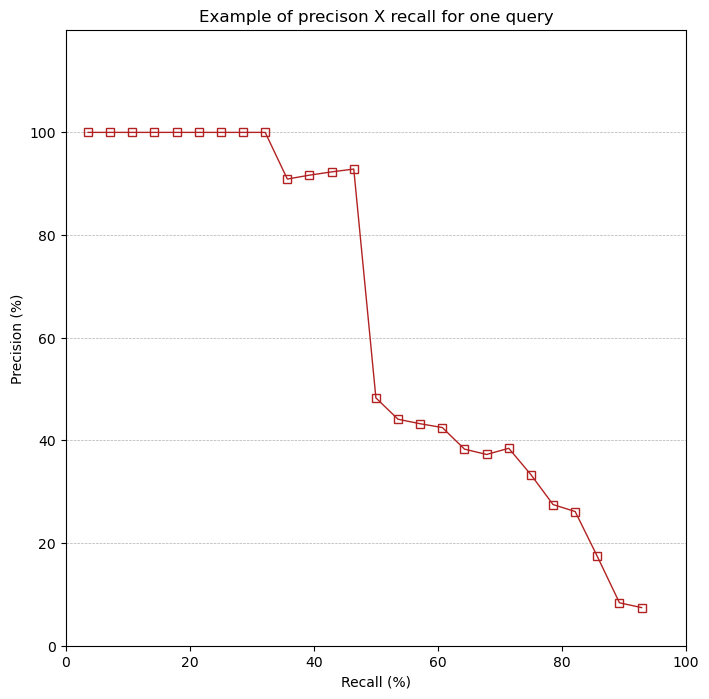

In [13]:
plt.figure(figsize=(8, 8))

plt.plot(pr_curve(ex_docs, res_docs, 90)["Recall"], pr_curve(ex_docs, res_docs, 90)["Precision"], 
         marker="s", markerfacecolor="none", ms=6, color="firebrick", linewidth=1)

plt.axis([0, 100, 0, 120])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)

plt.title("Example of precison X recall for one query")
plt.xlabel("Recall (%)")
plt.ylabel("Precision (%)")
plt.yticks([0, 20, 40, 60, 80, 100])

plt.show()

## 1.3 Criação da tabela contendo os 11 pontos de revocação para todas as consultas

Agora iremos contruir outra função, mas que junta todas as "curvas" das consultas em uma só tabela. Essas curvas são feitas a partir da função definida acima, mas utilizando a fórmula da precisão interpolada para que tenhamos apenas 11 pontos. A precisão interpolada é a maior precisão a direita de um valor de revocação.

In [14]:
def create_eleven_points_table(expected_docs, results_docs):
    # Primeiro criamos a tabela, com os 11 valores de revocação
    table = pd.DataFrame([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], columns=["Recall"])
    
    query_numbers = list(expected_docs.keys())
    # Iteramos pelos números das consultas
    for query_number in query_numbers:
        # Criamos uma coluna para cada consulta com nome pQX
        eleven_points = pd.Series([], name=f"pQ{query_number}")
        
        # Chamamos a função criada anteriormente, que nos retorna uma tabela de uma única consulta
        curve = pr_curve(ex_docs, res_docs, query_number)
        
        # Iteramos pelos 11 valores de revocação que desejamos, pegando o máximo valor de precisão a direita
        for index, r in enumerate(range(0, 101, 10)):
            eleven_points[index] = curve.loc[curve["Recall"] > r]["Precision"].max()
            
        # Juntamos a coluna na tabela contendo todas as demais    
        table = pd.concat([table, eleven_points], axis=1)
    
    # Quando um recall não for alcançado, o valor da precisão será 0
    table.fillna(0, inplace=True)
    
    return table

Demonstramos agora como fica a tabela contendo os 11 valores de revocação para cada consulta feita no mecanismo de busca.

In [15]:
eleven_points_df = create_eleven_points_table(ex_docs, res_docs)
eleven_points_df

,Recall,pQ1,pQ2,pQ3,pQ4,pQ5,pQ6,pQ7,pQ8,pQ9,...,pQ90,pQ91,pQ92,pQ94,pQ95,pQ96,pQ97,pQ98,pQ99,pQ100
0,0,31.818182,40.000000,100.000000,33.333333,100.000000,100.000000,100.000000,13.333333,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,10,31.818182,40.000000,38.461538,33.333333,59.259259,75.000000,50.000000,2.293578,28.571429,...,100.000000,38.372093,77.777778,83.333333,100.000000,50.000000,66.666667,100.000000,100.000000,100.000000
2,20,31.818182,40.000000,15.254237,16.666667,36.842105,27.777778,20.689655,2.293578,27.272727,...,100.000000,31.372549,71.794872,50.000000,100.000000,27.272727,50.000000,4.761905,100.000000,75.000000
3,30,26.829268,8.108108,14.772727,14.285714,34.677419,18.000000,9.090909,2.293578,19.047619,...,100.000000,31.372549,52.702703,33.333333,6.521739,22.222222,35.714286,3.546099,100.000000,22.222222
4,40,26.153846,8.108108,10.714286,14.285714,28.648649,15.384615,6.703911,2.293578,13.636364,...,92.857143,30.652174,25.000000,29.166667,1.731602,12.820513,35.714286,2.450980,100.000000,2.314815
5,50,23.376623,1.165501,7.213115,13.513514,0.000000,13.131313,4.292929,2.293578,13.636364,...,44.117647,29.980276,17.391304,27.058824,1.470588,5.833333,24.000000,2.450980,100.000000,2.140673
6,60,14.285714,1.165501,6.122449,9.090909,0.000000,8.333333,4.292929,2.293578,10.606061,...,42.500000,0.000000,14.446529,0.000000,1.145663,5.228758,10.714286,2.450980,1.438849,2.140673
7,70,5.797101,1.165501,4.718417,5.785124,0.000000,4.927536,3.056769,0.000000,10.000000,...,38.461538,0.000000,12.361111,0.000000,1.145663,1.453958,10.714286,2.335456,1.438849,2.044990
8,80,3.391813,0.000000,4.609475,3.305785,0.000000,3.846154,2.718007,0.000000,3.396226,...,26.136364,0.000000,0.000000,0.000000,0.000000,1.000000,10.714286,0.000000,0.914077,2.044990
9,90,0.000000,0.000000,4.362416,0.000000,0.000000,2.756892,0.000000,0.000000,0.000000,...,7.428571,0.000000,0.000000,0.000000,0.000000,0.000000,1.376721,0.000000,0.914077,2.044990


## 1.4 Criação da coluna com a média do mecanismo

Como temos os 11 pontos para todas as consultas, devemos apenas fazer a média, para obter os 11 pontos de revocação para o mecanismo. Isso será feito com a função declarada a seguir

In [16]:
def add_mean_precision(eleven_points_df):
    """Função que retorna uma tabela com a coluna com a precisão média do mecanismo adicionada."""
    
    pi = pd.Series([], name="pi")
    
    # Fazemos uma cópia da tabela com todos os 11 pontos de todas as consultas
    copy_11 = eleven_points_df.set_index(["Recall"])
    n_columns = len(copy_11.columns)
    
    # Iteramos pelas linhas (valores de revocação) e realizamos sua média
    for i in range(11):
        pi.loc[i] = copy_11.loc[i * 10].sum() / n_columns
        
    # Concatenamos a tabela maior com a nova coluna criada    
    eleven_points_df = pd.concat([eleven_points_df, pi], axis=1)
    
    return eleven_points_df

Mostramos como ficou a última coluna concatenada a tabela.

In [17]:
eleven_points_df = add_mean_precision(eleven_points_df)
eleven_points_df.to_csv("../avalia/11pontos-stemmer-1.csv")
eleven_points_df

,Recall,pQ1,pQ2,pQ3,pQ4,pQ5,pQ6,pQ7,pQ8,pQ9,...,pQ91,pQ92,pQ94,pQ95,pQ96,pQ97,pQ98,pQ99,pQ100,pi
0,0,31.818182,40.000000,100.000000,33.333333,100.000000,100.000000,100.000000,13.333333,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,82.935328
1,10,31.818182,40.000000,38.461538,33.333333,59.259259,75.000000,50.000000,2.293578,28.571429,...,38.372093,77.777778,83.333333,100.000000,50.000000,66.666667,100.000000,100.000000,100.000000,60.219075
2,20,31.818182,40.000000,15.254237,16.666667,36.842105,27.777778,20.689655,2.293578,27.272727,...,31.372549,71.794872,50.000000,100.000000,27.272727,50.000000,4.761905,100.000000,75.000000,43.007512
3,30,26.829268,8.108108,14.772727,14.285714,34.677419,18.000000,9.090909,2.293578,19.047619,...,31.372549,52.702703,33.333333,6.521739,22.222222,35.714286,3.546099,100.000000,22.222222,33.072941
4,40,26.153846,8.108108,10.714286,14.285714,28.648649,15.384615,6.703911,2.293578,13.636364,...,30.652174,25.000000,29.166667,1.731602,12.820513,35.714286,2.450980,100.000000,2.314815,25.694572
5,50,23.376623,1.165501,7.213115,13.513514,0.000000,13.131313,4.292929,2.293578,13.636364,...,29.980276,17.391304,27.058824,1.470588,5.833333,24.000000,2.450980,100.000000,2.140673,17.881586
6,60,14.285714,1.165501,6.122449,9.090909,0.000000,8.333333,4.292929,2.293578,10.606061,...,0.000000,14.446529,0.000000,1.145663,5.228758,10.714286,2.450980,1.438849,2.140673,12.173999
7,70,5.797101,1.165501,4.718417,5.785124,0.000000,4.927536,3.056769,0.000000,10.000000,...,0.000000,12.361111,0.000000,1.145663,1.453958,10.714286,2.335456,1.438849,2.044990,8.502578
8,80,3.391813,0.000000,4.609475,3.305785,0.000000,3.846154,2.718007,0.000000,3.396226,...,0.000000,0.000000,0.000000,0.000000,1.000000,10.714286,0.000000,0.914077,2.044990,4.861676
9,90,0.000000,0.000000,4.362416,0.000000,0.000000,2.756892,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.376721,0.000000,0.914077,2.044990,2.177977


## 1.5 Criação do gráfico de 11 pontos de revocação do mecanismo

Finalmente, chegamos ao objetivo de criar o gráfico abaixo. Ele é feito utilizando a tabela criada utilizando as funções acima.

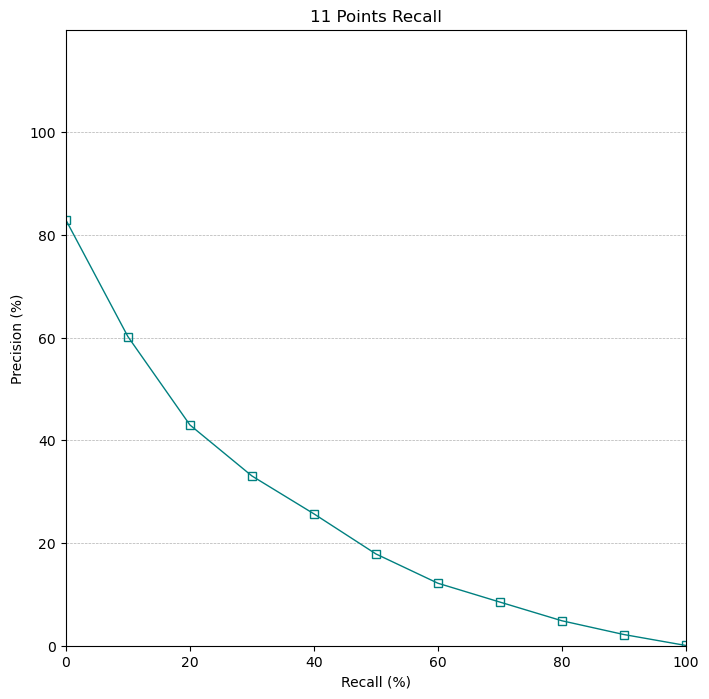

In [18]:
plt.figure(figsize=(8, 8))

plt.plot(eleven_points_df["Recall"], eleven_points_df["pi"], 
         marker="s", markerfacecolor="none", ms=6, color="teal", linewidth=1)

plt.axis([0, 100, 0, 120])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)

plt.title("11 Points Recall")
plt.xlabel("Recall (%)")
plt.ylabel("Precision (%)")
plt.yticks([0, 20, 40, 60, 80, 100])

plt.savefig("../avalia/11pontos-stemmer-1.png")
plt.show()

# 2. $F_1$
## 2.1 Revocação e Precisão para uma consulta

Para calcular o $F_1$, primeiro, devemos declarar a função que calcula os valores de revocação e precsião de uma determinada consulta. Como foi visto no início do notebook, usaremos os dicionários gerados pelas funções.

In [19]:
def query_recall(expected_docs, results_docs, query_number):
    # Teremos duas listas, os documentos relevantes da consulta, e os recuperados por ela
    relevant_docs = expected_docs[query_number]
    retrieved_docs = results_docs[query_number]
    
    # Relevantes Recuperados - A
    relevant_retrieved = 0
    for doc_number in retrieved_docs:
        if doc_number in relevant_docs:
            relevant_retrieved += 1
    
    # Total de relevantes - A + D
    relevant_total = len(relevant_docs)
    
    return relevant_retrieved / relevant_total

In [20]:
def query_precision(expected_docs, results_docs, query_number):
    # Teremos duas listas, os documentos relevantes da consulta, e os recuperados por ela
    relevant_docs = expected_docs[query_number]
    retrieved_docs = results_docs[query_number]
    
    # Relevantes Recuperados - A
    relevant_retrieved = 0
    for doc_number in retrieved_docs:
        if doc_number in relevant_docs:
            relevant_retrieved += 1
            
    # Total de relevantes - A + B
    retrieved_total = len(retrieved_docs)
    
    return relevant_retrieved / retrieved_total

Exemplo do uso das funções para uma consulta qualquer.

In [21]:
r = query_recall(ex_docs, res_docs, 90)
p = query_precision(ex_docs, res_docs, 90)
print(f"Revocação = {r}\nPrecisão = {p}")

Revocação = 0.9285714285714286
Precisão = 0.028888888888888888


## 2.2 Definição da função $F_1$ score

A função definida abaixo apenas aplica a fórmula da medida $F_1$ utilizando a revocação e a precisão calculadas pelas fnções acima.

In [22]:
def f1_score(p, r):
    return (2*p*r) / (p+r)

## 2.3 Criação de tabela e gráfico de cada consulta

Primeiro será construída uma tabela contendo todas as consultas e seus respectivos valores calculados de $F_1$. Depois teremos a visualização de um scatter plot mostrando cada valor para cada consulta.

In [23]:
def get_f1_table(expected_docs, results_docs):
    """Retorna uma tabela contendo o número da consulta e seu F1 score."""

    query_numbers = list(expected_docs.keys())
    # Cria tabela
    f1_table = pd.DataFrame([], columns=["F1", "QueryNumber"])
    
    # Itera pelos números das consultas
    for index, query_number in enumerate(query_numbers):
        # Calculamos a revocação, precisão e f1
        r = query_recall(expected_docs, results_docs, query_number)
        p = query_precision(expected_docs, results_docs, query_number)
        f1 = f1_score(p, r)
        
        # Adicona linha na tabela
        f1_table.loc[index] = [f1, query_number]
        
    return f1_table

Tabela contendo valor de $F_1$ e número da consulta.

In [24]:
f1 = get_f1_table(ex_docs, res_docs)
f1.to_csv("../avalia/f1-stemmer-3.csv")
f1.head()

,F1,QueryNumber
0,0.063806,1.0
1,0.016863,2.0
2,0.080868,3.0
3,0.061538,4.0
4,0.297521,5.0


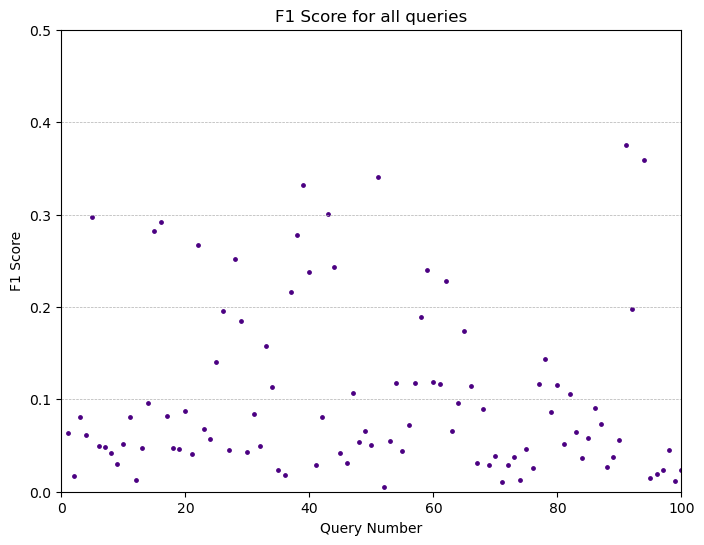

In [25]:
plt.figure(figsize=(8, 6))

plt.scatter(f1["QueryNumber"], f1["F1"], s=6, c="indigo")

plt.axis([0, 100, 0, 0.5])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)

plt.title("F1 Score for all queries")
plt.xlabel("Query Number")
plt.ylabel("F1 Score")

plt.show()

## 2.4 Obtenção do $F_1$ score médio do mecanismo

Podemos pegar a tabela criada pelas funções anteriores e obter o valor médio do mecanismo.

In [26]:
def get_avg_f1(f1_table):
    return f1_table["F1"].sum() / len(f1_table["F1"])

In [27]:
avg_f1 = get_avg_f1(f1)

Vamos utilizar essa função para plotar uma linha horizontal no gráfico com todos os valores de $F_1$.

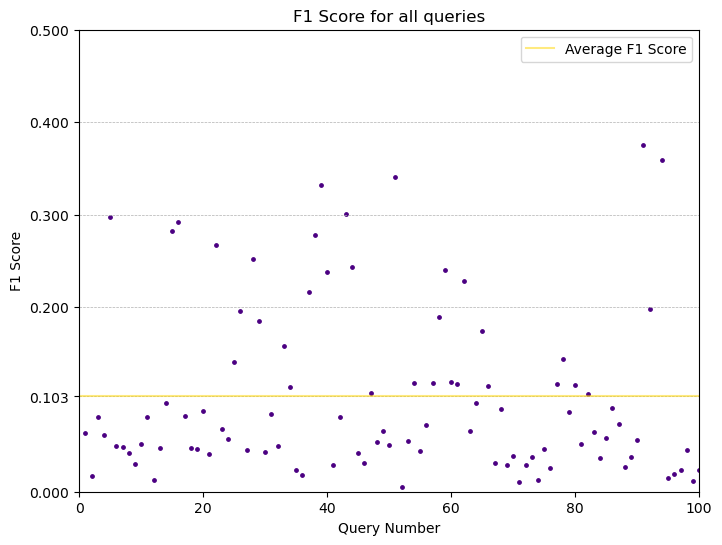

In [28]:
plt.figure(figsize=(8, 6))

plt.scatter(f1["QueryNumber"], f1["F1"], s=6, c="indigo")
plt.axhline(avg_f1, alpha=0.5, color="gold", label="Average F1 Score")

plt.axis([0, 100, 0, 0.5])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)

plt.title("F1 Score for all queries")
plt.xlabel("Query Number")
plt.ylabel("F1 Score")
plt.yticks([0, avg_f1, 0.2, 0.3, 0.4, 0.5])
plt.legend()

plt.savefig("../avalia/f1-stemmer-3.png")
plt.show()

# 3. Precision@K

Definimos a precisão de uma consulta baseada nos top-K documentos retornados pelo mecanismo. Para o cálculo dessa precisão, utilizaremos a função `precision` definida no tópico 1.1 deste notebook. Relembrando, ela necessita que passemos as duas listas de uma determinada consulta, espera e retornada, respectivamente. Então, passaremos a lista esperada inteira de uma consulta, mas na lista retornada, passaremos apenas os top-K documentos, e com isso, teremos o valor de Precision@K. É mostrado o exemplo do uso abaixo, com o K=10 na consulta 90.

In [29]:
correct_list = ex_docs[90]
returned_list = res_docs[90]
precision(correct_list, returned_list[:10])

90.0

Podemos criar uma função para ajustar o valor de `K` quando for necessário.

In [30]:
def get_precision_at_k(k, expected_docs, results_docs, query_number):
    # Pega as listas de documentos nos dicionário
    correct_list = expected_docs[query_number]
    returned_list = results_docs[query_number]
    
    # Passa como argumento a lista de resultados esperados e os top-K resultados retornados
    return precision(correct_list, returned_list[:k])

## 3.1 Criar tabela com todas as consultas e suas respectivas Precision@K

Vamos criar uma tabela contendo todas as consultas e seus valores de precisão, tal como fizemos com o valor de $F_1$.

In [31]:
def get_p_at_k_table(k, expected_docs, results_docs):
    """Retorna uma tabela contendo o número da consulta e seu Precision@K score."""

    query_numbers = list(ex_docs.keys())
    # Cria tabela
    pk_table = pd.DataFrame([], columns=[f"P@{k}", "QueryNumber"])
    
    # Itera pelos números das consultas
    for index, query_number in enumerate(query_numbers):
        # Calculamos a precisão
        pk = get_precision_at_k(k, expected_docs, results_docs, query_number)
        
        # Adicona linha na tabela
        pk_table.loc[index] = [pk, query_number]
        
    return pk_table

Mostramos um exemplo da tabela para Precision@3.

In [32]:
get_p_at_k_table(3, ex_docs, res_docs).head()

,P@3,QueryNumber
0,0.000000,1.0
1,33.333333,2.0
2,66.666667,3.0
3,33.333333,4.0
4,66.666667,5.0


Agora vamos utilizar essa função para gerar as avaliações para Precision@5 e Precision@10 do mecanismo de busca construído. 

In [33]:
p5 = get_p_at_k_table(5, ex_docs, res_docs)
p10 = get_p_at_k_table(10, ex_docs, res_docs)
# Salvamos ambos como CSV
p5.to_csv("../avalia/precision@5-stemmer-5.csv")
p10.to_csv("../avalia/precision@10-stemmer-7.csv")

## 3.2 Calcular o valor da média para um mecanismo de Precision@K

O cálculo aqui se dará da mesma forma em que foi feito para o tópico 2.

In [34]:
def get_avg_p_at_k(k, pk_table):
    return pk_table[f"P@{k}"].sum() / len(pk_table[f"P@{k}"])

## 3.3 Criação dos gráficos para Precision@K

Utilizamos as tabelas geradas pela função mostrada acima para a criação de um scatter plot, tal qual feito para o $F_1$ score.

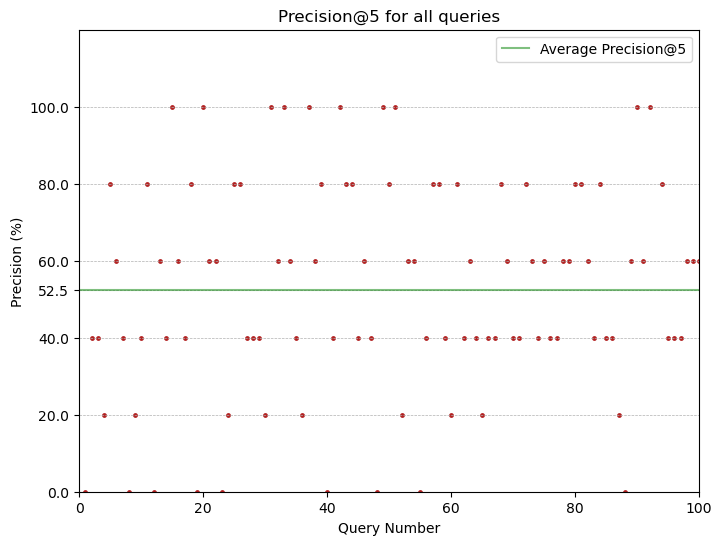

In [35]:
plt.figure(figsize=(8, 6))

plt.scatter(p5["QueryNumber"], p5["P@5"], s=6, c="firebrick")
plt.axhline(get_avg_p_at_k(5, p5), alpha=0.5, color="green", label="Average Precision@5")

plt.axis([0, 100, 0, 120])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)

plt.title("Precision@5 for all queries")
plt.xlabel("Query Number")
plt.ylabel("Precision (%)")
plt.yticks([0, 20, 40, get_avg_p_at_k(5, p5), 60, 80, 100])
plt.legend()

plt.savefig("../avalia/precision@5-stemmer-5.png")
plt.show()

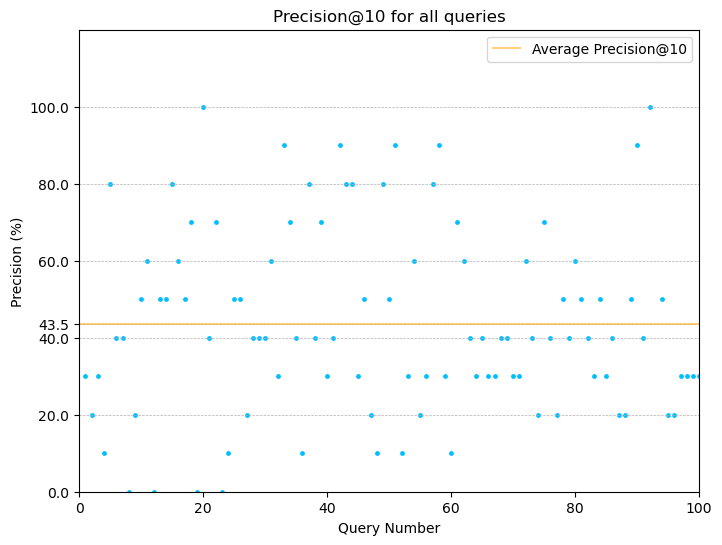

In [36]:
plt.figure(figsize=(8, 6))

plt.scatter(p10["QueryNumber"], p10["P@10"], s=6, c="deepskyblue")
plt.axhline(get_avg_p_at_k(10, p10), alpha=0.5, color="orange", label="Average Precision@10")

plt.axis([0, 100, 0, 120])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)

plt.title("Precision@10 for all queries")
plt.xlabel("Query Number")
plt.ylabel("Precision (%)")
plt.yticks([0, 20, 40, get_avg_p_at_k(10, p10), 60, 80, 100])
plt.legend()

plt.savefig("../avalia/precision@10-stemmer-7.png")
plt.show()

# 4. R-Precision

## 4.1 Criação de função para cálculo de R-precision para cada consulta

A função declarada abaixo calcula o R-precision dividindo o número de documentos relevantes recuperados pelo mecanismo pelo número total de documentos relevantes.

In [37]:
def get_r_precision(expected_docs, results_docs, query_number):
    # Teremos duas listas, os documentos relevantes da consulta, e os recuperados por ela
    relevant_docs = expected_docs[query_number]
    retrieved_docs = results_docs[query_number]
            
    # Sabemos o total de relevantes - Y
    relevant_total = len(relevant_docs)
    
    # Algumas consultas podem ter mais esperados do que retornados
    total = relevant_total
    retrieved_total = len(retrieved_docs)
    if relevant_total > retrieved_total:
        total = retrieved_total
    
    # Então vamos ver quantos documentos corretos temos no top-Y da resposta do mecanismo
    correct_retrieved = 0
    for i in range(total):
        if retrieved_docs[i] in relevant_docs:
            correct_retrieved += 1
    
    return correct_retrieved / relevant_total * 100

## 4.2 Criação de tabela para todas as consultas

In [38]:
def get_r_precision_table(expected_docs, results_docs):
    """Retorna uma tabela contendo o número da consulta e seu R-Precision."""

    query_numbers = list(expected_docs.keys())
    # Cria tabela
    r_precision_table = pd.DataFrame([], columns=[f"R-Precision", "QueryNumber"])
    
    # Itera pelos números das consultas
    for index, query_number in enumerate(query_numbers):
        # Calculamos a precisão
        rp = get_r_precision(expected_docs, results_docs, query_number)
        
        # Adicona linha na tabela
        r_precision_table.loc[index] = [rp, query_number]
        
    return r_precision_table

Exemplo da tabela criada.

In [39]:
r_precision_stemmer = get_r_precision_table(ex_docs, res_docs)
r_precision_stemmer.head()

,R-Precision,QueryNumber
0,23.529412,1.0
1,28.571429,2.0
2,16.279070,3.0
3,11.111111,4.0
4,33.587786,5.0


Como nesse tópico faremos um histograma comparativo entre os mecanismos utilizando o stemmer ou não, definiremos o dicionário para os resultados gerados quando não utilizamos o stemmer. 

In [40]:
results_nostemmer = pd.read_csv("../results/results-nostemmer.csv", sep=";", converters={"DocInfos": pd.eval})
nostemmer_res_docs = get_results_docs(results_nostemmer)

In [41]:
r_precision_nostemmer = get_r_precision_table(ex_docs, nostemmer_res_docs)
r_precision_nostemmer.head()

,R-Precision,QueryNumber
0,26.470588,1.0
1,28.571429,2.0
2,18.604651,3.0
3,0.000000,4.0
4,32.061069,5.0


Vamos pegar uma das tabelas, copiar e colocar a coluna com a diferença entre o R-precision dos mecanismos com stemmer e sem o stemmer. Além disso, essa tabela também será salva como um arquivo de formato CSV.

In [42]:
diff_r_precision = r_precision_stemmer.rename(columns={"R-Precision": "Diff-R-Precision"})
diff_r_precision["Diff-R-Precision"] = r_precision_stemmer["R-Precision"] - r_precision_nostemmer["R-Precision"]
diff_r_precision.to_csv("../avalia/r-precision-comparativo-9.csv")
diff_r_precision.tail()

,Diff-R-Precision,QueryNumber
94,-8.333333,96.0
95,-9.090909,97.0
96,0.000000,98.0
97,0.000000,99.0
98,0.000000,100.0


## 4.3 Criação do gráfico comparativo

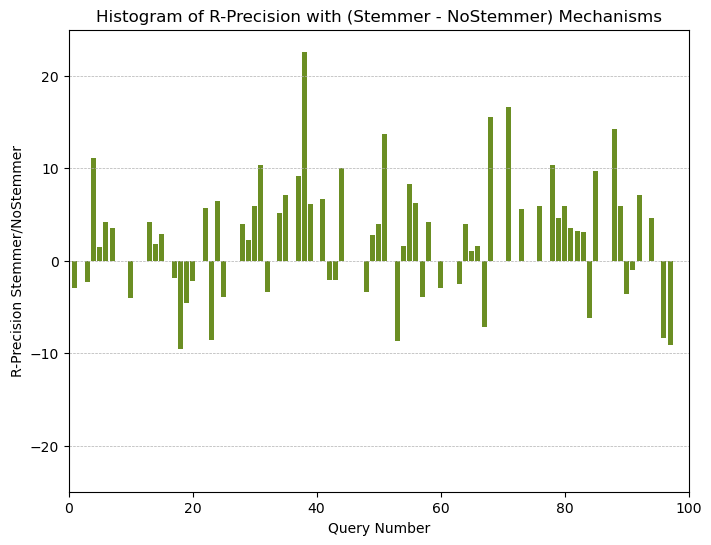

In [43]:
plt.figure(figsize=(8, 6))

plt.bar(diff_r_precision["QueryNumber"], diff_r_precision["Diff-R-Precision"], color="olivedrab")

plt.axis([0, 100, -25, 25])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)

plt.title("Histogram of R-Precision with (Stemmer - NoStemmer) Mechanisms")
plt.xlabel("Query Number")
plt.ylabel("R-Precision Stemmer/NoStemmer")

plt.savefig("../avalia/r-precision-comparativo-9.png")
plt.show()

# 5. MAP

## 5.1 Obtenção dos valores de MVP

O MAP é a média das médias das precisões das consultas. Portanto, primeiro será declarada uma função que mede a precisão média de uma consulta, o valor MVP.

In [44]:
def get_mvp(expected_docs, results_docs, query_number):
    # Teremos duas listas, os documentos relevantes da consulta, e os recuperados por ela
    relevant_docs = expected_docs[query_number]
    retrieved_docs = results_docs[query_number]
    
    # Teremos a lista com as precisões quando cada documento relevante é encontrado na lista de documentos
    # recuperados
    precisions = []
    
    # Itermaos por todos os documentos recuperados
    for index, doc_number in enumerate(retrieved_docs):
        
        # Caso o documento seja relevante
        if doc_number in relevant_docs:
            # Calculamos a sua precisão passando a lista de documentos certos e a lista de documentos recuperados
            # até ele
            p = precision(relevant_docs, retrieved_docs[:index+1])
            precisions.append(p)
    
    # Assumimos precisão zero para documentos relevantes que não foram recuperados
    while len(precisions) < len(relevant_docs):
        precisions.append(0.0)
    
    # Soma-se a lista 'precisions'
    total = 0
    for v in precisions:
        total += v
    
    mvp = total / len(precisions)
    
    return mvp

## 5.2 Criação da tabela com todos os MVP's

Com essa função, podemos calcular o valor de MVP para todas as consultas e juntá-los em uma tabela.

In [45]:
def get_mvp_table(expected_docs, results_docs):
    """Retorna uma tabela contendo o número da consulta e seu valor médio de precisão."""
    query_numbers = list(expected_docs.keys())
    
    # Cria a tabela
    mvp_table = pd.DataFrame([], columns=["MVP", "QueryNumber"])
    
    # Itera pelos números de documentos
    for index, query_number in enumerate(query_numbers):
        # Calcula o valor para cada consulta
        mvp = get_mvp(expected_docs, results_docs, query_number)
        # Adiciona os valores na tabela
        mvp_table.loc[index] = [mvp, query_number]
    
    return mvp_table

Exemplo de como fica a tabela com os valores de MVP.

In [46]:
mvp = get_mvp_table(ex_docs, res_docs)
mvp.to_csv("../avalia/map-stemmer-10.csv")
mvp.head()

,MVP,QueryNumber
0,16.666649,1.0
1,11.940365,2.0
2,13.925063,3.0
3,11.946612,4.0
4,19.519468,5.0


## 5.3 Obtenção do valor do MAP

É a soma dos valores dos MVP's das consultas dividido pelo número de consultas.

In [47]:
def get_map(mvp_table):
    return mvp_table["MVP"].sum() / len(mvp_table["MVP"])

## 5.4 Criação do gráfico com MVP's e MAP

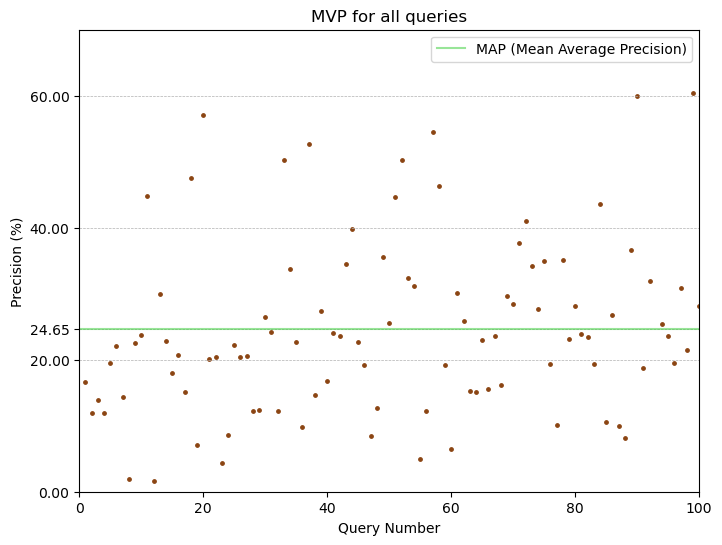

In [48]:
plt.figure(figsize=(8, 6))

plt.scatter(mvp["QueryNumber"], mvp["MVP"], s=6, c="saddlebrown")
plt.axhline(get_map(mvp), alpha=0.5, color="limegreen", label="MAP (Mean Average Precision)")

plt.axis([0, 100, 0, 70])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)

plt.title("MVP for all queries")
plt.xlabel("Query Number")
plt.ylabel("Precision (%)")
plt.yticks([0, 20, get_map(mvp), 40, 60])
plt.legend()

plt.savefig("../avalia/map-stemmer-10.png")
plt.show()

# 6. MRR

Nessa medida primeiro vamos calcular o RR (Reciprocal Rank) para cada consulta. O valor de RR é dado dividindo 1 pela posição do primeiro documento relevante que foi recuperado pelo mecanismo de busca. Além disso, é necessário estabelecer um limite K, em que se um documento relevante não aparecer após K documentos recuperados, o seu valor de RR será igual a 0. Seguindo o enunciado do trabalho, esse valor de limite K será igual a 10. Com os valores de RR de todas as consultas em mãos, basta calcular a sua média, que teremos o MRR.

## 6.1 Calculando o RR para cada consulta

In [49]:
def get_rr(expected_docs, results_docs, query_number):
    k = 10
    
    # Teremos duas listas, os documentos relevantes de uma consulta, e os k primeiros recuperados por ela
    relevant_docs = expected_docs[query_number]
    retrieved_docs = results_docs[query_number][:k]
    
    for position, doc_number in enumerate(retrieved_docs):
        if doc_number in relevant_docs:
            return 1 / (position + 1) * 100
    
    return 0.0

## 6.2 Criando tabela com todos os RR's

In [50]:
def get_rr_table(expected_docs, results_docs):
    query_numbers = list(expected_docs.keys())
    
    # Cria a tabela
    rr_table = pd.DataFrame([], columns=["RR", "QueryNumber"])
    
    # Itera pelos números de documentos
    for index, query_number in enumerate(query_numbers):
        # Calcula o valor para cada consulta
        rr = get_rr(expected_docs, results_docs, query_number)
        # Adiciona os valores na tabela
        rr_table.loc[index] = [rr, query_number]
    
    return rr_table

Exemplo da tabela criada acima.

In [51]:
rr = get_rr_table(ex_docs, res_docs)
rr.to_csv("../avalia/mrr-stemmer-12.csv")
rr.head()

,RR,QueryNumber
0,16.666667,1.0
1,33.333333,2.0
2,100.000000,3.0
3,33.333333,4.0
4,100.000000,5.0


## 6.3 Obtenção do valor de MRR

In [52]:
def get_mrr(rr_table):
    return rr_table["RR"].sum() / len(rr_table["RR"])

## 6.4 Criação do gráfico com RR's e MRR

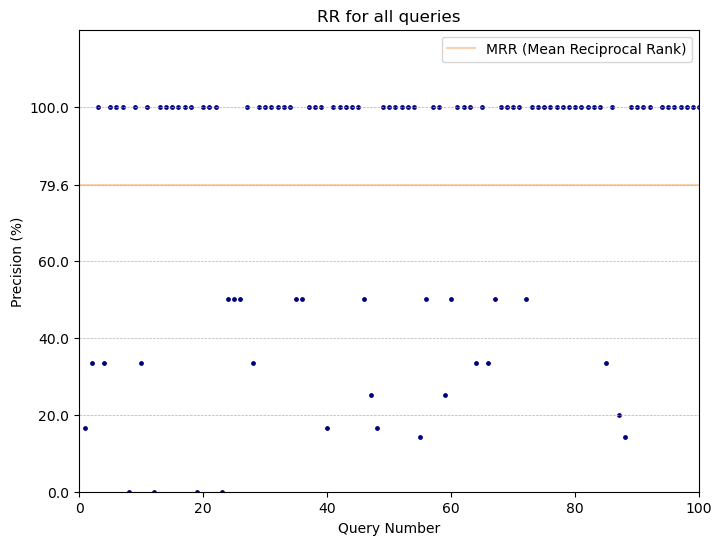

In [53]:
plt.figure(figsize=(8, 6))

plt.scatter(rr["QueryNumber"], rr["RR"], s=6, c="navy")
plt.axhline(get_mrr(rr), alpha=0.5, color="sandybrown", label="MRR (Mean Reciprocal Rank)")

plt.axis([0, 100, 0, 120])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)

plt.title("RR for all queries")
plt.xlabel("Query Number")
plt.ylabel("Precision (%)")
plt.yticks([0, 20, 40, 60,  get_mrr(rr), 100])
plt.legend()

plt.savefig("../avalia/mrr-stemmer-12.png")
plt.show()

# 7. DCG

Para essa medida, precisamos saber o quanto cada documento é relevante. Isso será feito utilizando o campo 'DocVotes' do arquivo de resultados esperados das consultas. Antes, utilizamos um dicionário para acessar os documentos relevantes, contendo a consulta como chave e os números dos documentos como valor. Agora precisaremos criar uma função para obter o grau de relevância de um documento X em uma consulta Y.

## 7.1 Definição de função que retorna grau de relevância de um documento em uma consulta

Essa função usará o DataFrame construído a partir do arquivo de resultados esperados, extraindo o número da consulta e o número do documento, retornando então o campo 'DocVotes' que corresponde a sua relevância

In [54]:
def get_gain(expected_df, query_number, doc_number):
    # Primeiro pegamos toda a parte do DF que corresponde a consulta passada
    expected_query = expected.loc[expected["QueryNumber"] == query_number]
    # Depois pegamos a linha em que o documento corresponde com o desejado
    expected_doc = expected_query.loc[expected["DocNumber"] == doc_number]
    # Finalmente pegamos o campo 'DocVotes' dessa linha
    gain = expected_doc["DocVotes"]
    
    # Se o documento não for relevante, não teremos essa linha (gain será uma pd.Series vazia) 
    # e portanto a função deve retornar zero
    if gain.empty:
        return 0
    else:
        # Como gain é uma Series, devemos desencapsular o seu valor
        i = list(gain.index)[0]
        return gain[i]

## 7.2 Definição da função para obter o vetor de ganho acumulado descontado (DCG) de uma consulta

Essa função será feita pegando os ganhos dos documentos recuperados pelo mecanismo, e os armazenando em um vetor. Os documentos que serão levados em conta, são os 10 primeiros. A função terá como parâmetros, o DataFrame de documentos relevantes (esperados), os dicionários de documentos relevantes e recuperados e o número da consulta que se deseja calcular o vetor DCG. 

In [55]:
def get_dcg(expected_df, results_docs, query_number):
    k = 10
    # Teremos a lista dos k primeiros recuperados pelo mecanismo
    retrieved_docs = results_docs[query_number][:k]
    
    cg_vector = []
    # Cria o vetor de ganhos da consulta
    for doc_number in retrieved_docs:
        gain = get_gain(expected_df, query_number, doc_number)
        cg_vector.append(gain)
        
    dcg = [cg_vector[0]]
    
    for i in range(1, k):
        dcg_i = dcg[i-1] + (cg_vector[i] / math.log2(i + 1))
        dcg.append(dcg_i)
    
    return dcg

Exemplo de um vetor DCG calculado para uma consulta.

In [56]:
get_dcg(expected, res_docs, 90)

[4,
 8.0,
 10.523719014285831,
 12.523719014285831,
 13.81574868850601,
 15.363159917444177,
 16.431781478768244,
 17.431781478768244,
 18.0627112323397,
 18.0627112323397]

## 7.3 Criação de tabela contendo as posições dos vetores DCG's para cada consulta

In [57]:
def get_dcg_table(expected_df, expected_docs, results_docs):
    query_numbers = list(expected_docs.keys())
    
    # Cria a tabela
    dcg_table = pd.DataFrame([], columns=["QueryNumber"])
    
    # Adicionamos colunas com as 10 posições do vetor DCG
    for i in range(1, 11):
        dcg_table[i] = 0
    
    # Itera pelos números de documentos
    for index, query_number in enumerate(query_numbers):
        # Calcula o valor para cada consulta
        dcg = get_dcg(expected_df, results_docs, query_number)
        
        # Adiciona os valores na tabela
        dcg_table.loc[index] = [query_number, *dcg]
    
    return dcg_table

Agora que já temos os vetores DCG para todas as consultas, podemos calcular o vetor médio, no qual estamos interessados. Um exemplo da tabela criada é mostrado abaixo.

In [58]:
dcg = get_dcg_table(expected, ex_docs, res_docs)
dcg.head()

,QueryNumber,1,2,3,4,5,6,7,8,9,10
0,1.0,0.0,0.0,0.000000,0.000000,0.000000,1.547411,1.903618,1.903618,1.903618,3.107738
1,2.0,0.0,0.0,0.630930,0.630930,1.061606,1.061606,1.061606,1.061606,1.061606,1.061606
2,3.0,4.0,4.0,6.523719,6.523719,6.523719,6.523719,6.523719,6.523719,6.839184,6.839184
3,4.0,0.0,0.0,2.523719,2.523719,2.523719,2.523719,2.523719,2.523719,2.523719,2.523719
4,5.0,4.0,5.0,5.000000,5.500000,5.930677,7.478088,7.834295,7.834295,8.465225,9.669345


In [59]:
def add_mean_dcg(dcg_table):
    mdcg = dcg_table
    means = []
    
    # Teremos todas as colunas menos a QueryNumber
    columns = list(mdcg.columns)[1:]
    for c in columns:
        mean = mdcg[c].sum() / len(mdcg[c])
        means.append(mean)
    
    # Adicionar linha com as médias para cada posição no final da tabela
    # O QueryNumber será 0, pois não é uma consulta
    mdcg.loc[len(mdcg)] = [0, *means]
    
    return mdcg

Agora pegamos a tabela já criada e adicionamos uma linha no final contendo o vetor DCG médio.

In [60]:
dcg = add_mean_dcg(dcg)
dcg.to_csv("../avalia/dcg-stemmer-14.csv")
dcg.tail()

,QueryNumber,1,2,3,4,5,6,7,8,9,10
95,97.0,4.000000,4.000000,5.892789,5.892789,5.892789,7.440200,7.440200,7.440200,7.440200,7.440200
96,98.0,2.000000,5.000000,5.630930,5.630930,5.630930,5.630930,5.630930,5.630930,5.630930,5.630930
97,99.0,4.000000,8.000000,10.523719,10.523719,10.523719,10.523719,10.523719,10.523719,10.523719,10.523719
98,100.0,4.000000,8.000000,8.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
99,0.0,2.444444,4.212121,5.129837,5.740948,6.254280,6.770084,7.126291,7.392284,7.682257,7.885984


## 7.4 Criação do gráfico utilizando o vetor DCG médio

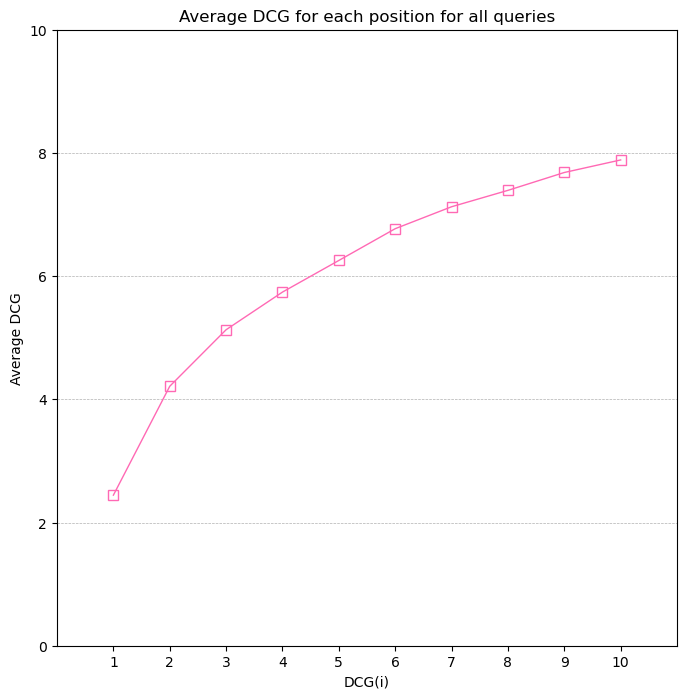

In [61]:
plt.figure(figsize=(8, 8))

plt.plot(dcg.T[99][1:], 
         marker="s", markerfacecolor="none", ms=7, color="hotpink", linewidth=1)

plt.axis([0, 11, 0, 10])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)

plt.title("Average DCG for each position for all queries")
plt.xlabel("DCG(i)")
plt.ylabel("Average DCG")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.yticks([0, 2, 4, 6, 8, 10])

plt.savefig("../avalia/dcg-stemmer-14.png")
plt.show()

# 8. NDCG

Aqui precisaremos utilizar os mesmos conceitos que usamos no DCG, mas calcular um vetor DCG ideal para uma consulta qualquer. Então o vetor NDCG será uma divisão entre o vetor DCG, que já calculamos, com esse vetor ideal, com esse cálculo aplicado a cada posição. 

## 8.1 Calculando um vetor de posições ideias

In [62]:
def get_ndcg(expected_df, results_docs, query_number):
    k = 10
    # Teremos a lista dos k primeiros recuperados pelo mecanismo
    retrieved_docs = results_docs[query_number][:k]
    
    cg_vector = []
    # Cria o vetor de ganhos da consulta
    for doc_number in retrieved_docs:
        gain = get_gain(expected_df, query_number, doc_number)
        cg_vector.append(gain)
        
    # Vamos ordenar esse vetor para obter o vetor de resposta ideal
    cg_vector.sort(reverse=True)
    
    # Calcular o dcg do vetor ideal
    best_dcg = [cg_vector[0]]
    for i in range(1, k):
        dcg_i = best_dcg[i-1] + (cg_vector[i] / math.log2(i + 1))
        best_dcg.append(dcg_i)
        
    dcg = get_dcg(expected_df, results_docs, query_number)
    
    # Agora temos o DCG e o DCG', basta fazer a divisão para cada posição e retornar o NDCG
    ndcg = []
    for i in range(10):
        if best_dcg[i] != 0:
            ndcg_i = dcg[i] / best_dcg[i]
        else:
            ndcg_i = 0
        ndcg.append(ndcg_i)
        
    return ndcg

In [63]:
get_ndcg(expected, res_docs, 1)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.17928673655324925,
 0.2205577464303282,
 0.2205577464303282,
 0.2205577464303282,
 0.360069944656442]

## 8.2 Criação da tabela contendo os vetores de NDCG para todas as consultas

In [64]:
def get_ndcg_table(expected_df, expected_docs, results_docs):
    query_numbers = list(expected_docs.keys())
    
    # Cria a tabela
    ndcg_table = pd.DataFrame([], columns=["QueryNumber"])
    
    # Adicionamos colunas com as 10 posições do vetor DCG
    for i in range(1, 11):
        ndcg_table[i] = 0
    
    # Itera pelos números de documentos
    for index, query_number in enumerate(query_numbers):
        # Calcula o valor para cada consulta
        ndcg = get_ndcg(expected_df, results_docs, query_number)
        
        # Adiciona os valores na tabela
        ndcg_table.loc[index] = [query_number, *ndcg]
    
    return ndcg_table

Abaixo é mostrado como fica a tabela.

In [65]:
ndcg = get_ndcg_table(expected, ex_docs, res_docs)
ndcg.head()

,QueryNumber,1,2,3,4,5,6,7,8,9,10
0,1.0,0.0,0.000,0.000000,0.000000,0.000000,0.179287,0.220558,0.220558,0.220558,0.360070
1,2.0,0.0,0.000,0.315465,0.315465,0.530803,0.530803,0.530803,0.530803,0.530803,0.530803
2,3.0,1.0,0.500,0.755854,0.755854,0.755854,0.755854,0.755854,0.755854,0.792404,0.792404
3,4.0,0.0,0.000,0.630930,0.630930,0.630930,0.630930,0.630930,0.630930,0.630930,0.630930
4,5.0,1.0,0.625,0.475117,0.477276,0.496108,0.605943,0.616997,0.601214,0.649633,0.742038


In [66]:
def add_mean_ndcg(ndcg_table):
    mndcg = ndcg_table
    means = []
    
    # Teremos todas as colunas menos a QueryNumber
    columns = list(mndcg.columns)[1:]
    for c in columns:
        mean = mndcg[c].sum() / len(mndcg[c])
        means.append(mean)
    
    # Adicionar linha com as médias para cada posição no final da tabela
    # O QueryNumber será 0, pois não é uma consulta
    mndcg.loc[len(mndcg)] = [0, *means]
    
    return mndcg

Agora pegamos a tabela já criada e adicionamos uma linha no final contendo o vetor NDCG médio.

In [67]:
ndcg = add_mean_ndcg(ndcg)
ndcg.to_csv("../avalia/ndcg-stemmer-16.csv")
ndcg.tail()

,QueryNumber,1,2,3,4,5,6,7,8,9,10
95,97.0,1.000000,0.500000,0.595665,0.595665,0.595665,0.752083,0.752083,0.752083,0.752083,0.752083
96,98.0,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
97,99.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
98,100.0,1.000000,1.000000,0.760188,0.950234,0.950234,0.950234,0.950234,0.950234,0.950234,0.950234
99,0.0,0.616162,0.581145,0.584085,0.598081,0.623979,0.660773,0.683246,0.700564,0.724038,0.742301


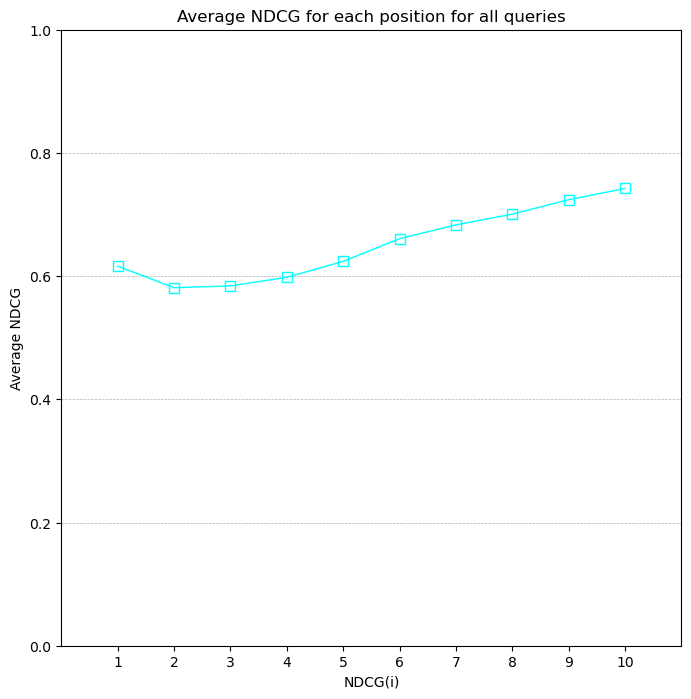

In [68]:
plt.figure(figsize=(8, 8))

plt.plot(ndcg.T[99][1:], 
         marker="s", markerfacecolor="none", ms=7, color="cyan", linewidth=1)

plt.axis([0, 11, 0, 1.0])
plt.grid(axis="y", linestyle = '--', linewidth=0.5)

plt.title("Average NDCG for each position for all queries")
plt.xlabel("NDCG(i)")
plt.ylabel("Average NDCG")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.savefig("../avalia/ndcg-stemmer-16.png")
plt.show()